* http://minato.sip21c.org/bulbul/20140127.html
* https://twitter.com/minatonakazawa/status/1202738229180416000

以下は

* http://minato.sip21c.org/epispecial/codes-for-Chapter8.R

のFigure 8-4の部分のほぼ忠実なJulia版.

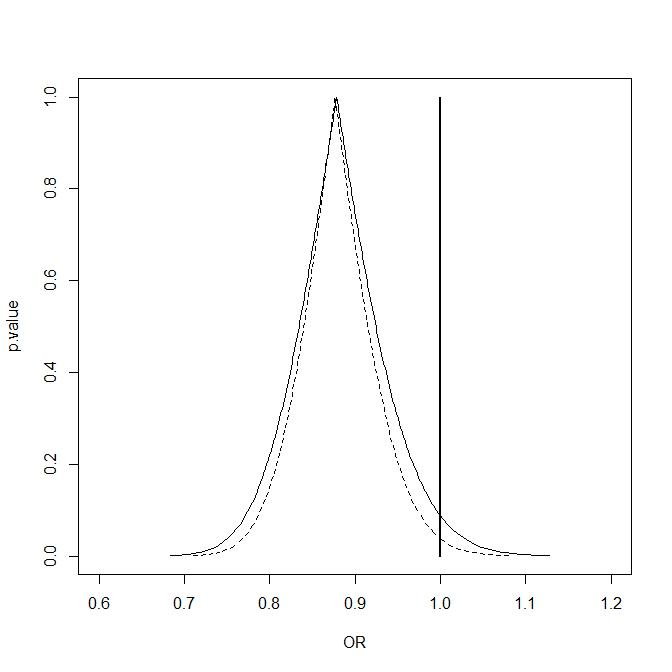

In [1]:
using Distributions
using StatsPlots
default(fmt = :png)

In [2]:
function ORMH(TBL; conf_level = 0.95)
    TT = sum.(eachrow(TBL))
    GG = @views @. TBL[:,1] * TBL[:,4] / TT
    HH = @views @. TBL[:,2] * TBL[:,3] / TT
    OR = sum(GG) / sum(HH)
    PP = @views @. (TBL[:,1] + TBL[:,4]) / TT
    QQ = @views @. (TBL[:,2] + TBL[:,3]) / TT
    VARlnOR = @views sum(@. GG*PP)/(2sum(GG)^2) + sum(@. GG*QQ+HH*PP)/(2sum(GG)*sum(HH)) + sum(@. HH*QQ)/(2sum(HH)^2)
    SElnOR = √VARlnOR # \sqrt TAB → √
    ORL = exp(log(OR) - quantile(Normal(), 1 - (1 - conf_level)/2)*SElnOR)
    ORU = exp(log(OR) + quantile(Normal(), 1 - (1 - conf_level)/2)*SElnOR)
    (estimate = OR, conf_int = (ORL, ORU), conf_level = conf_level)
end

ORMH (generic function with 1 method)

In [3]:
TenStudies = [
    215 229 311-215 306-229
     38  33  59-38   51-33
    161 174 293-161 293-174
     76  88 164-76  163-88
    103 105 129-103 133-105
     65  67 120-65  125-67
     81  75 113-81  110-75
     48  63 160-48  159-63
     22  21  60-22  62-21
     56  51 137-56  140-51
]

10×4 Matrix{Int64}:
 215  229   96   77
  38   33   21   18
 161  174  132  119
  76   88   88   75
 103  105   26   28
  65   67   55   58
  81   75   32   35
  48   63  112   96
  22   21   38   41
  56   51   81   89

In [4]:
ElevenStudies = [
    TenStudies
    468 480 229 205
]

11×4 Matrix{Int64}:
 215  229   96   77
  38   33   21   18
 161  174  132  119
  76   88   88   75
 103  105   26   28
  65   67   55   58
  81   75   32   35
  48   63  112   96
  22   21   38   41
  56   51   81   89
 468  480  229  205

In [5]:
ORMH(TenStudies)

(estimate = 0.8781804164991955, conf_int = (0.7565860364363417, 1.0193167819422062), conf_level = 0.95)

In [6]:
ORMH(ElevenStudies)

(estimate = 0.8765652832028286, conf_int = (0.7738329501187079, 0.9929361312394176), conf_level = 0.95)

In [7]:
function pvpORMH!(XTAB; xlim = (0.6, 1.2), kwargs...)
    cp = [(1:9)./1000; (1:9)./100; (10:90)./100; 0.9 .+ (1:9)./100; 0.99 .+ (1:9)./1000]
    cl = 1 .- cp
    lu = zeros(length(cl))
    uu = zeros(length(cl))
    for i in 1:length(cl)
        res = ORMH(XTAB; conf_level = cl[i])
        lu[i] = res.conf_int[1]
        uu[i] = res.conf_int[2]
    end
    cpx = [cp; 1; reverse(cp)]
    cOR = [lu; ORMH(XTAB).estimate; reverse(uu)]
    plot!(cOR, cpx; xlim, kwargs...)
end

pvpORMH! (generic function with 1 method)

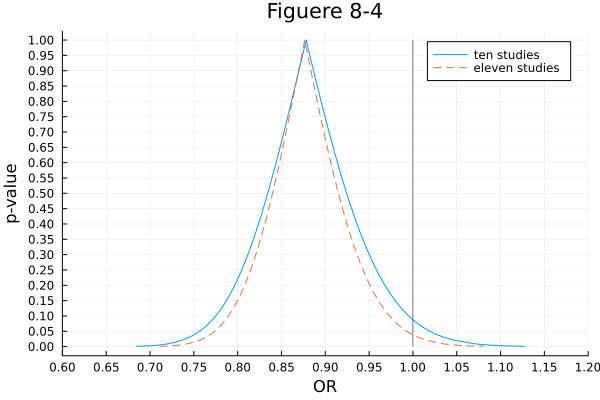

In [8]:
plot(; title="Figuere 8-4")
pvpORMH!(TenStudies; label="ten studies")
pvpORMH!(ElevenStudies; label="eleven studies", ls=:dash)
plot!([1, 1], [0, 1]; label="", c=:black, lw=0.5)
plot!(; xtick = 0.6:0.05:1.2, ytick = 0:0.05:1)
plot!(; xlabel="OR", ylabel="p-value")

## P値函数を直接定義

以上では「信頼区間を大量に計算することによってP値函数をプロットする」という実装になっているが, 以下ではP値函数を直接定義することによって同一のグラフをプロットしてみる.

In [9]:
function logOR_and_SE_normalapprox(TBL)
    TT = sum.(eachrow(TBL))
    GG = @views @. TBL[:,1] * TBL[:,4] / TT
    HH = @views @. TBL[:,2] * TBL[:,3] / TT
    OR = sum(GG) / sum(HH)
    PP = @views @. (TBL[:,1] + TBL[:,4]) / TT
    QQ = @views @. (TBL[:,2] + TBL[:,3]) / TT
    VARlnOR = @views sum(@. GG*PP)/(2sum(GG)^2) + sum(@. GG*QQ+HH*PP)/(2sum(GG)*sum(HH)) + sum(@. HH*QQ)/(2sum(HH)^2)
    SElnOR = √VARlnOR # \sqrt TAB → √
    (logOR = log(OR), SE = SElnOR)
end

function pval_ORMH_normalapprox(TBL, or = 1.0)
    (; logOR, SE) = logOR_and_SE_normalapprox(TBL)
    normal = Normal(logOR, SE)
    min(1, 2cdf(normal, log(or)), 2ccdf(normal, log(or)))
end

pval_ORMH_normalapprox (generic function with 2 methods)

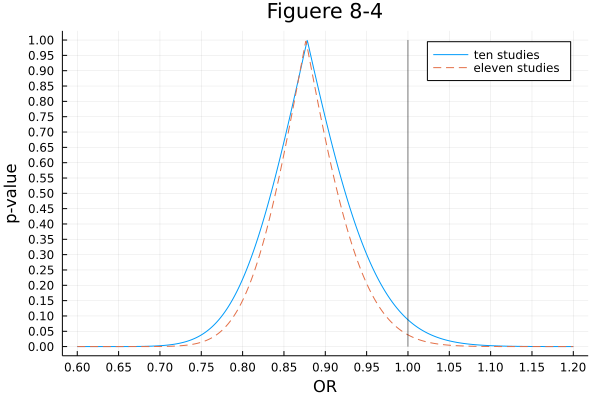

In [10]:
or = range(0.6, 1.2, 1000)
plot(; title="Figuere 8-4")
plot!(or, or -> pval_ORMH_normalapprox(TenStudies, or); label="ten studies")
plot!(or, or -> pval_ORMH_normalapprox(ElevenStudies, or); label="eleven studies", ls=:dash)
plot!([1, 1], [0, 1]; label="", c=:black, lw=0.5)
plot!(; xtick = range(extrema(or)...; step=0.05), ytick = 0:0.05:1)
plot!(; xlabel="OR", ylabel="p-value")

__比較:__ 以下のように2つの方法によるプロットはぴったり一致している.

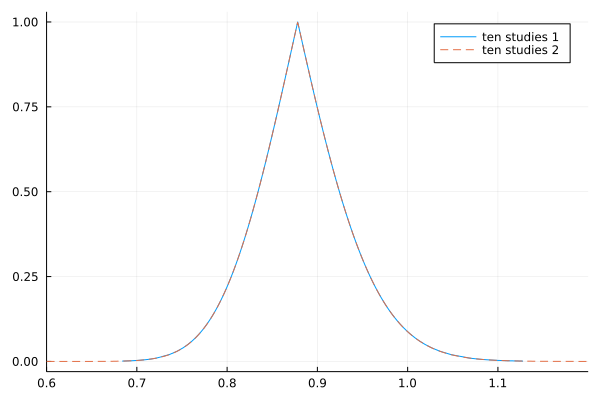

In [11]:
or = range(0.6, 1.2, 1000)
plot()
pvpORMH!(TenStudies; label="ten studies 1", xlim=extrema(or))
plot!(or, or -> pval_ORMH_normalapprox(TenStudies, or); label="ten studies 2", ls=:dash)

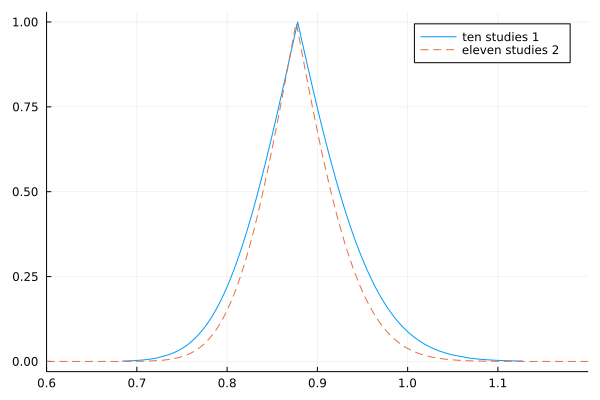

In [12]:
or = range(0.6, 1.2, 1000)
plot()
pvpORMH!(TenStudies; label="ten studies 1", xlim=extrema(or))
plot!(or, or -> pval_ORMH_normalapprox(ElevenStudies, or); label="eleven studies 2", ls=:dash)

## オッズ比が1以外の場合に拡張されたMantel-Haenszel検定のP値函数

オッズ比が1以外の場合に拡張されたMantel-Haenszel検定のP値函数は以下のようにして構成可能である(導出は独自).

「共通のオッズ比は $\omega$ である」という仮説のP値函数を構成しよう.

$i = 1,2,\ldots,r$ について, $i$ 番目の2×2の分割表を

$$
\begin{bmatrix}
a_i & b_i \\
c_i & d_i \\
\end{bmatrix}
$$

と書き,

$$
N_i = a_i + b_i + c_i + d_i
$$

とおく.  共通のオッズ比を $\omega > 0$ と書く.

(1) 統計量 $\delta_i$ を

$$
\frac{(a_i - \delta_i)(d_i - \delta_i)}{(b_i + \delta_i)(c_i + \delta_i)} = \omega, \quad
-\min(b,c) < \delta_i < \min(a,d)
$$

という条件によって $\delta_i$ を定める. すなわち

$$
A_i = 1 - \omega, \quad
B_i = a_i + d_i + \omega(b_i + c_i), \quad
C_i = a_i d_i - \omega b_i c_i
$$

とおくと,

$$
\delta_i = \frac{2C_i}{B_i + \sqrt{B_i^2 - 4A_i C_i}}.
$$

これは2次方程式 $A_i x^2 - B_i x + C_i = 0$ の解の1つである.  例えば, $\omega = 1$ のとき

$$
\delta_i = a_i - \frac{(a_i+b_i)(a_i+c_i)}{N_i} = \frac{a_i d_i - b_i c_i}{N_i}
$$

(2) 統計量 $v_i$ を

$$
v_i = 
\frac{N_i-1}{N_i}
\left(\frac{1}{a_i-\delta_i} + \frac{1}{b_i+\delta_i} + \frac{1}{c_i+\delta_i} + \frac{1}{d_i-\delta_i}\right)^{-1}
$$

と定める.  例えば, $\omega = 1$ のとき, $v_i$ は超幾何分布の分散に一致する:

$$
v_i = \frac{(a_i+b_i)(c_i+d_i)(a_i+c_i)(b_i+d_i)}{N_i^2(N_i - 1)}.
$$

(3) 統計量 $Z^2$ を次のように定める:

$$
Z^2 = \frac{\left(\sum_{i=1}^r \delta_i\right)^2}{\sum_{i=1}^r v_i}
$$

例えば, $\omega = 1$ のとき, これは次のようにMantel-Haenszelのχ²統計量に一致する:

$$
Z^2 = \frac
{\left(\sum_{i=1}^r (a_i - (a_i+b_i)(a_i+c_i)/N_i)\right)^2}
{\sum_{i=1}^r (a_i+b_i)(c_i+d_i)(a_i+c_i)(b_i+d_i)/(N_i^2(N_i-1))}.
$$

さらに $r=1$ とすると, 

$$
Z^2 = \frac{(N_1 - 1)(a_1 d_1 - b_1 c_1)^2}{(a_1+b_1)(c_1+d_1)(a_1+c_1)(b_1+d_1)}.
$$

これは単独の2×2の分割表の独立性検定のPearsonのχ²統計量の $(N_1 - 1)/N_1$ 倍に一致する.

(4) P値を自由度 $1$ のχ²分布で $Z^2$ 以上になる確率と定める.

In [13]:
using Roots

safediv(x, y) = x == 0 ? x/one(y) : x/y
safesqrt(x) = √max(0, x)

function delta_or(a, b, c, d, ω = 1.0)
    A = 1 - ω
    B = a + d + ω*(b + c)
    C = a*d - ω*b*c
    # solution of Ax² - Bx + C = 0 with −min(b,c) < x < min(a,d)
    safediv(2C, B + safesqrt(B^2 - 4*A*C))
end

function mhvar_or(a, b, c, d, ω)
    N = a + b + c + d
    δ = delta_or(a, b, c, d, ω)
    (N - 1)/N/(1/(a - δ) + 1/(b + δ) + 1/(c + δ) + 1/(d - δ))
end

function zsq_stat_or(a, b, c, d, ω = 1.0)
    safediv(
        sum(((a, b, c, d),) -> delta_or(a, b, c, d, ω), zip(a, b, c, d))^2, 
        sum(((a, b, c, d),) -> mhvar_or(a, b, c, d, ω), zip(a, b, c, d))
    )
end

function zsq_stat_or(tbl, ω = 1.0)
    @views a, b, c, d = tbl[:,1], tbl[:,2], tbl[:,3], tbl[:,4]
    zsq_stat_or(a, b, c, d, ω)
end

function pval_mantelhaenszel_or(tbl, ω = 1.0)
    Z² = zsq_stat_or(tbl, ω)
    ccdf(Chisq(1), Z²)
end

function ci_mantelhaenszel_or(tbl, α = 0.05)
    f(t) = pval_mantelhaenszel_or(tbl, exp(t)) - α
    logci = find_zeros(f, -1e1, 1e1)
    exp(logci[begin]), exp(logci[end])
end

ci_mantelhaenszel_or (generic function with 2 methods)

In [14]:
@show pval_ORMH_normalapprox(TenStudies)
@show pval_mantelhaenszel_or(TenStudies)
@show pval_ORMH_normalapprox(ElevenStudies)
@show pval_mantelhaenszel_or(ElevenStudies);

pval_ORMH_normalapprox(TenStudies) = 0.08757101848883674
pval_mantelhaenszel_or(TenStudies) = 0.08661968813950241
pval_ORMH_normalapprox(ElevenStudies) = 0.03831919505862904
pval_mantelhaenszel_or(ElevenStudies) = 0.037876956707385036


In [15]:
@show ORMH(TenStudies).conf_int
@show ci_mantelhaenszel_or(TenStudies)
@show ORMH(ElevenStudies).conf_int
@show ci_mantelhaenszel_or(ElevenStudies);

(ORMH(TenStudies)).conf_int = (0.7565860364363417, 1.0193167819422062)
ci_mantelhaenszel_or(TenStudies) = (0.7564370173217948, 1.018894296145525)
(ORMH(ElevenStudies)).conf_int = (0.7738329501187079, 0.9929361312394176)
ci_mantelhaenszel_or(ElevenStudies) = (0.7737258422531788, 0.9926435960137233)


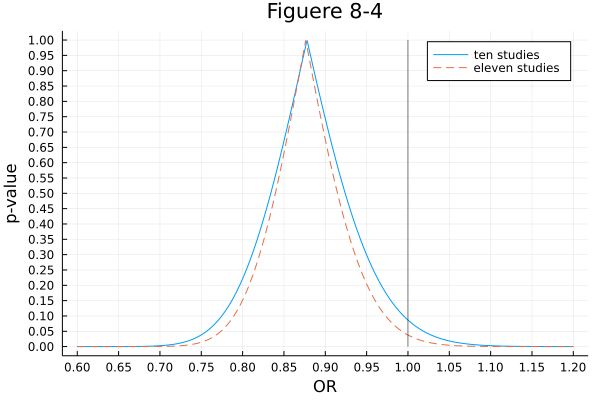

In [16]:
or = range(0.6, 1.2, 1000)
plot(; title="Figuere 8-4")
plot!(or, or -> pval_mantelhaenszel_or(TenStudies, or); label="ten studies")
plot!(or, or -> pval_mantelhaenszel_or(ElevenStudies, or); label="eleven studies", ls=:dash)
plot!([1, 1], [0, 1]; label="", c=:black, lw=0.5)
plot!(; xtick = range(extrema(or)...; step=0.05), ytick = 0:0.05:1)
plot!(; xlabel="OR", ylabel="p-value")

__比較:__ 以下のように正規分布近似によるP値函数とスコア検定のP値函数はこの場合にはよく一致している.

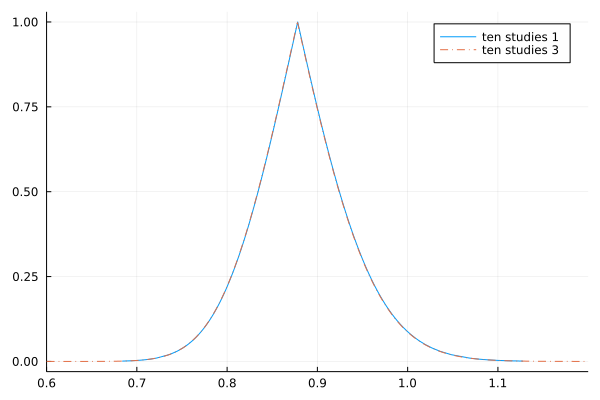

In [17]:
or = range(0.6, 1.2, 1000)
plot()
pvpORMH!(TenStudies; label="ten studies 1", xlim=extrema(or))
plot!(or, or -> pval_mantelhaenszel_or(TenStudies, or); label="ten studies 3", ls=:dashdot)

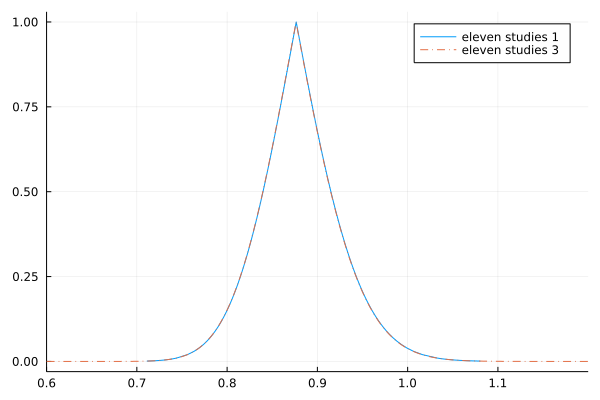

In [18]:
or = range(0.6, 1.2, 1000)
plot()
pvpORMH!(ElevenStudies; label="eleven studies 1", xlim=extrema(or))
plot!(or, or -> pval_mantelhaenszel_or(ElevenStudies, or); label="eleven studies 3", ls=:dashdot)

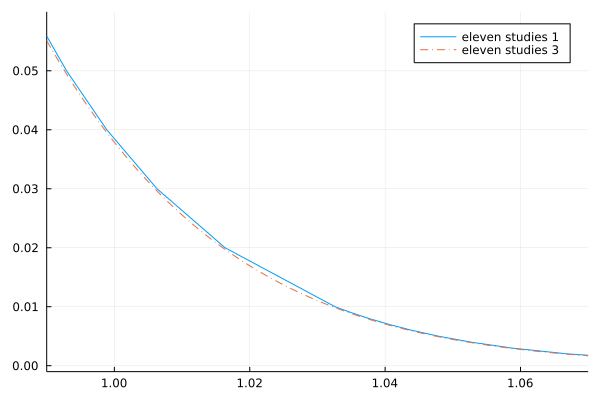

In [19]:
or = range(0.99, 1.07, 1000)
plot()
pvpORMH!(ElevenStudies; label="eleven studies 1", xlim=extrema(or), ylim=(-0.001, 0.06))
plot!(or, or -> pval_mantelhaenszel_or(ElevenStudies, or); label="eleven studies 3", ls=:dashdot)

__比較:__ 以下のように、標本サイズを10分の1にした場合でも, 正規分布近似によるP値函数とスコア検定のP値函数はこの場合にはよく一致している.

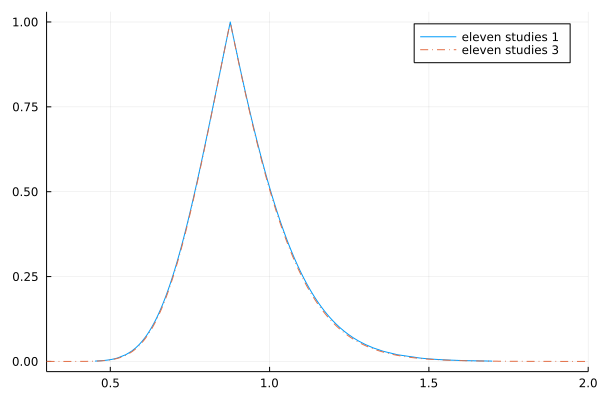

In [20]:
or = range(0.3, 2, 1000)
plot()
pvpORMH!(ElevenStudies/10; label="eleven studies 1", xlim=extrema(or))
plot!(or, or -> pval_mantelhaenszel_or(ElevenStudies/10, or); label="eleven studies 3", ls=:dashdot)

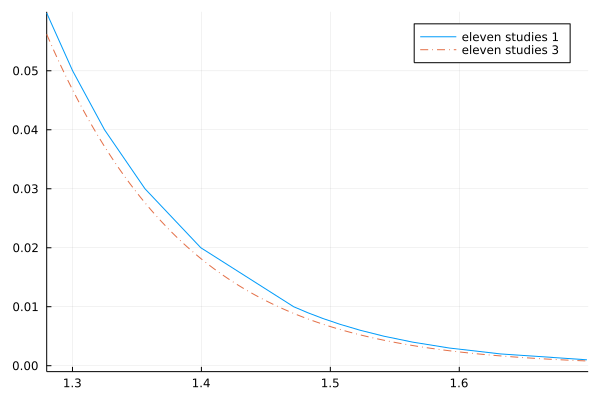

In [21]:
or = range(1.28, 1.7, 1000)
plot()
pvpORMH!(ElevenStudies/10; label="eleven studies 1", xlim=extrema(or), ylim=(-0.001, 0.06))
plot!(or, or -> pval_mantelhaenszel_or(ElevenStudies/10, or); label="eleven studies 3", ls=:dashdot)